In [1]:
import os
import torch
import numpy as np
import argparse

from guided_diffusion.script_util import (
    NUM_CLASSES,
    model_and_diffusion_defaults,
    classifier_defaults,
    create_model_and_diffusion,
    create_classifier,
    add_dict_to_argparser,
    args_to_dict,
    ResNet18_32x32,
)


/atlas2/u/haotiany/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def create_argparser():
    defaults = dict(
        clip_denoised=True,
        num_samples=10000,
        batch_size=16,
        use_ddim=False,
        use_ddjm=False,
        model_path="",
        log_dir="tmp",
        classifier_path="",
        guide_mode="None",
        classifier_scale=0.0,
        positive_label="None",
        progress=False,
        eta=0.0,
        ref_batch=None,
        test_classifier_path="",
        model_id=None,
        iteration=10,
        shrink_cond_x0=True,    # whether to shrink the score of x0 by at
        faceid_loss_type='cosine',
        face_image1_id='00000',
        face_image2_id='00000',
        face_image3_id='00000',
        plot_args=False,
        score_norm=1e09,
        plot_traj=False,
    )
    defaults.update(model_and_diffusion_defaults())
    defaults.update(classifier_defaults())
    
    return defaults
    # parser = argparse.ArgumentParser()
    # add_dict_to_argparser(parser, defaults)
    # return parser

args = create_argparser()
# change dict to args, write your own code
class Args:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

args = Args(**args)
args.image_size = 32

In [3]:
npath = './ckpts/cifar_classifier/not_best_epoch96_acc0.9470.ckpt'
nmodel = ResNet18_32x32()
# load state dict
nmodel.load_state_dict(torch.load(npath))


class TModel(torch.nn.Module):
    def __init__(self, model):
        super(TModel, self).__init__()
        self.model = model
    
    def forward(self, x):
        return self.model(x, torch.tensor([0] * x.shape[0], device=x.device))

tpath = './ckpts/cifar_classifier/model099999.pt'
tmodel = create_classifier(**args_to_dict(args, classifier_defaults().keys()))
# load state dict
tmodel.load_state_dict(torch.load(tpath,))
tmodel = TModel(tmodel)

acc_path = "nateraw/vit-base-patch16-224-cifar10"


nmodel.eval()
tmodel.eval()
# to cuda
nmodel.cuda()
tmodel.cuda()


TModel(
  (model): EncoderUNetModel(
    (time_embed): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
    (input_blocks): ModuleList(
      (0): TimestepEmbedSequential(
        (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): TimestepEmbedSequential(
        (0): ResBlock(
          (in_layers): Sequential(
            (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
            (1): SiLU()
            (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (h_upd): Identity()
          (x_upd): Identity()
          (emb_layers): Sequential(
            (0): SiLU()
            (1): Linear(in_features=512, out_features=256, bias=True)
          )
          (out_layers): Sequential(
            (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
            (1): SiLU()
            (2): Dropout(

In [4]:
# load data
label = 1
# data_path = f'./evaluations/ref/cifar_test_{label}.npz'
# data_path = "./working/witht_classifier_cifar/steps=200+pipe=ddim+iter=1+mode=manifold+scale=20.0+shrink=True/samples_1024x32x32x3.npz"
data_path = "./working/temp_mc_trynew/steps=50+pipe=ddim+iter=2+mode=mcsqscale0.01_1+scale=10.0+shrink=True+recurrent=5/samples_1024x32x32x3.npz"
try:
    data = np.load(data_path)
except:
    data_path = data_path.replace("samples_1024", "samples_64")
    data = np.load(data_path)
# data.shape
data = data['arr_0']
data = data.transpose(0, 3, 1, 2) / 127.5 - 1
data.min(), data.max()

(-1.0, 1.0)

In [5]:
x = torch.tensor(data, dtype=torch.float32)
x = x.cuda()
x.shape

torch.Size([1024, 3, 32, 32])

In [6]:
btz = 64
n_btz = x.shape[0] // btz
x.requires_grad_(False)
fake_p, real_p = [], []
for i in range(n_btz):
    fake_p.append(nmodel(x[btz*i:btz*(i+1)]).argmax(1))
fake_p = torch.concat(fake_p)
for i in range(n_btz):
    real_p.append(tmodel(x[btz*i:btz*(i+1)]).argmax(1))
real_p = torch.concat(real_p)
print(
    (fake_p == label).float().mean()
)
print(
    (real_p == label).float().mean()
)
real_p[:64].reshape(8,8)

tensor(1., device='cuda:0')
tensor(0.4912, device='cuda:0')


tensor([[7, 9, 1, 1, 1, 1, 1, 1],
        [1, 8, 8, 9, 1, 8, 1, 1],
        [9, 1, 8, 8, 1, 1, 1, 1],
        [1, 1, 1, 1, 7, 7, 2, 1],
        [7, 1, 6, 9, 9, 1, 1, 1],
        [9, 9, 1, 1, 7, 1, 8, 1],
        [3, 7, 8, 1, 1, 2, 1, 1],
        [1, 9, 1, 7, 8, 1, 7, 1]], device='cuda:0')

In [7]:
from evaluations.classifier import compute_accuracy
test_p = compute_accuracy("nateraw/vit-base-patch16-224-cifar10", data_path, label, return_preds=True)
test_p = torch.tensor(test_p).cuda()
test_p.shape

2024-05-02 00:34:46.542713: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 00:34:46.692417: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-02 00:34:46.726768: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-02 00:34:52.277596: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

torch.Size([1024])

In [8]:
(test_p == label).float().mean()

tensor(0.6631, device='cuda:0')

In [9]:
import torch.nn.functional as F

def get_grad(model, x, label):
    x_in = x.detach().requires_grad_(True)
    logits = model(x_in)
    log_probs = F.log_softmax(logits, dim=-1)
    selected = log_probs[:, label]
    return torch.autograd.grad(selected.sum(), x_in)[0]



In [10]:
ngrad = get_grad(nmodel, x[:btz], label)
tgrad = get_grad(tmodel, x[:btz], label)

ngrad.shape, tgrad.shape


(torch.Size([64, 3, 32, 32]), torch.Size([64, 3, 32, 32]))

In [11]:
# cosine similarity of two tensors, where the first dimension is the batch dimension
def cosine_similarity(a, b):
    a, b = a.reshape(a.shape[0], -1), b.reshape(b.shape[0], -1)

    return (a * b).sum(dim=-1) / (a.norm(dim=-1) * b.norm(dim=-1))

In [12]:
cosine_similarity(ngrad, tgrad).mean()

tensor(0.0071, device='cuda:0')

In [13]:
ngrad.reshape(ngrad.shape[0], -1).norm(dim=-1).mean(), tgrad.reshape(tgrad.shape[0], -1).norm(dim=-1).mean()

(tensor(0.1361, device='cuda:0'), tensor(2.6624, device='cuda:0'))

In [14]:
mdl = nmodel
noise = torch.randn_like(x)
# noise_grad = get_grad(nmodel, x + 0.1 * noise, label)
pgd = x.clone() #+ 0.05 * noise
for _ in range(10):
    # pgd = pgd + 0.01 * torch.randn_like(pgd)
    pgd = pgd - get_grad(mdl, pgd, label)
    # project into the epsilon ball with x as center
    # notice that shape of pgd and x is (btz, 3, 32, 32)

    diff = pgd - x
    diff = diff.reshape(x.shape[0], -1)
    norm = torch.sum(diff ** 2, dim=1, keepdim=True).sqrt()
    xnorm = torch.sum(x.reshape(x.shape[0], -1) ** 2, dim=1, keepdim=True).sqrt()
    # print(xnorm[:5], norm[:5])
    # print(diff.norm(p=2, dim=1).mean())
    ths = 0.05 * xnorm
    diff = torch.where(norm > ths, diff / norm * ths, diff)
    # diff = diff.renorm(p=2, dim=1, maxnorm=0.2)
    # print(diff.norm(p=2, dim=1).mean())
    diff = diff.reshape(x.shape[0], 3, 32, 32)
    pgd = x + diff


out = F.log_softmax(mdl(pgd), dim=-1)

print(out.shape)
# out = F.log_softmax(nmodel(x[:btz] + 0.1 * noise), dim=-1)
sq = 8
# out[:,label].reshape(sq, sq), 
print("Prediction of our filter")
our_p = out.argmax(dim=1)
print(our_p[:sq*sq].reshape(sq,sq))
print("Real classifier prediction")
print(test_p[:sq*sq].reshape(sq,sq))

tt = (test_p == our_p)[our_p == label]
tt.shape, tt.float().mean(), (test_p == label).float().mean()

torch.Size([1024, 10])
Prediction of our filter
tensor([[6, 0, 0, 3, 3, 1, 0, 1],
        [9, 1, 8, 9, 1, 8, 1, 9],
        [9, 1, 1, 3, 3, 9, 9, 1],
        [3, 1, 1, 8, 3, 3, 5, 1],
        [5, 1, 3, 0, 0, 1, 1, 0],
        [9, 3, 1, 1, 1, 1, 0, 9],
        [0, 0, 6, 1, 1, 3, 1, 1],
        [1, 1, 1, 3, 3, 9, 3, 1]], device='cuda:0')
Real classifier prediction
tensor([[6, 9, 7, 1, 4, 1, 1, 1],
        [1, 1, 1, 9, 1, 8, 1, 1],
        [9, 1, 1, 1, 5, 9, 1, 1],
        [1, 1, 1, 1, 0, 8, 7, 1],
        [9, 1, 9, 9, 9, 1, 1, 1],
        [9, 1, 1, 1, 1, 1, 7, 9],
        [3, 8, 1, 1, 1, 9, 1, 1],
        [1, 1, 1, 7, 8, 9, 7, 1]], device='cuda:0')


(torch.Size([411]),
 tensor(0.8978, device='cuda:0'),
 tensor(0.6631, device='cuda:0'))

In [16]:
mask = (out[:, label] > out[:, label].median())
(label == test_p)[mask].float().mean()

tensor(0.8398, device='cuda:0')

In [17]:
from scripts.classifier_sample import save_images

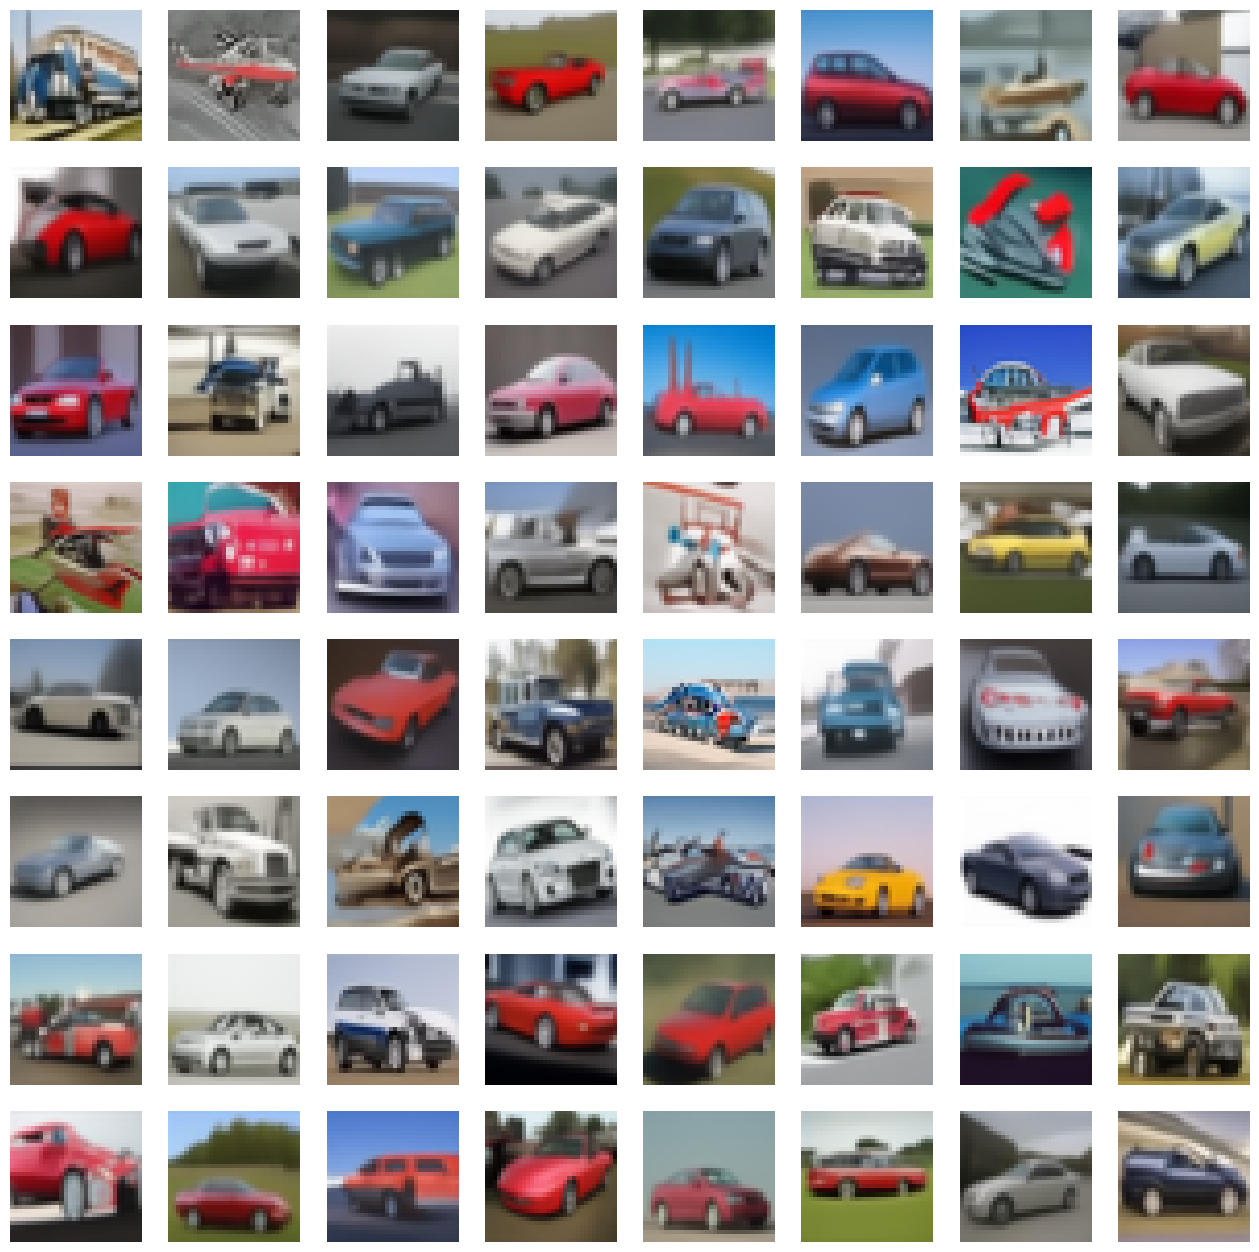

In [19]:
sample = x[mask].cpu()

sample = ((sample + 1) * 127.5).clamp(0, 255).to(torch.uint8)
sample = sample.permute(0, 2, 3, 1)
save_images(sample, f"lhw_x_mask=True.png", )

In [108]:
# check the smooth of x in the pixel space
# more specifically, use convolution to check

import torch.nn.functional as F
import torch.nn as nn

class Conv(nn.Module):
    def __init__(self):
        super(Conv, self).__init__()
        self.conv = nn.Conv2d(3, 3, 3, 1, 1, bias=False)
        self.conv.weight.data = torch.tensor([[[[0, 0, 0], [0, 1, 0], [0, 0, 0]]]*3], dtype=torch.float32)
        self.conv.weight.requires_grad = False

    def forward(self, x):
        return self.conv(x)
    
conv = Conv()
conv.cuda()
conv(x[:btz]).shape

conv(x[:btz]).abs().reshape(16, -1).mean(axis=-1)

tensor([0.6101, 0.8454, 0.6359, 0.9746, 1.4401, 0.7621, 0.7286, 1.2745, 1.1093,
        0.8565, 0.8104, 1.2374, 1.0279, 0.9560, 0.9478, 0.8909],
       device='cuda:0')